# Setup

In [392]:
from glob import glob
import json
import os
from os.path import join

import matplotlib.pyplot as plt
import multicam_calibration as mcc
import numpy as np
from o2_utils.selectors import find_files_from_pattern
import pandas as pd
from scipy.spatial.distance import pdist
from tqdm.notebook import tqdm
import yaml

In [2]:
def euclidean_distances(A, B):
    """Compute the Euclidean distances between points in A and B."""
    squared_diffs = np.sum((A - B) ** 2, axis=-1)
    return np.sqrt(squared_diffs)

# Curate

*NB: This notebook only works for frames where you have annotations from >= 3 cameras.*

## Load scale annotations

* Loads scale annotations from the task.json format

In [259]:
all_img_dirs = [

    # JP data
    "/n/groups/datta/Jonah/20240308_hrnet_finetuning/scale_annotation/JP_219_rig_v1/images/images/",
    "/n/groups/datta/Jonah/20240308_hrnet_finetuning/scale_annotation/JP_219_rig_v2_May2024/images",       

    # CW data
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230822_J01704_b",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230903_J01601",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230903_J01602",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230903_J01701",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230903_J01702",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230903_J01703",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230904_J01601",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230904_J01602",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230904_J01701",
   "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/20230904_J01703",
   "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/23_12_25_PL5",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/23_12_25_PL6",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/24_1_16_GRAB1",  # CW says calibration might be weidr for these sessions
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/24_1_16_GRAB2",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/24_1_16_GRAB3",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/24_1_16_GRAB4",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/PFC_nesting",
    # "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/24_4_2_inscopix_test_puck",
    # "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/24_4_2_inscopix_test_puck_2",
    # "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/24_4_2_inscopix_test_puck_3",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/images/JEP",
]

all_results_dirs = [
    "/n/groups/datta/Jonah/20240308_hrnet_finetuning/scale_annotation/JP_219_rig_v1/results/",
    "/n/groups/datta/Jonah/20240308_hrnet_finetuning/scale_annotation/JP_219_rig_v2_May2024/results/",
    "/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23_8_11_sniff/scale_annotation/results/",
]

In [262]:
# Find all images
all_img_paths = []
all_img_names = []
for img_dir in all_img_dirs:
    all_img_paths.extend(glob(join(img_dir, "*.jpg")))
    all_img_names.extend([os.path.basename(p) for p in all_img_paths])
img_paths_by_img_name = {os.path.basename(p): p for p in all_img_paths}

In [224]:
# Load all annotations
all_camera_names = ["top", "side1", "side2", "side3", "side4", "bottom"]
all_annos = []
for result_dir in all_results_dirs:
    results_files = glob(join(result_dir, "tasks*.json"))
    for fname in results_files:
        if "cleaned" in fname:
            continue

        # Load annotations
        with open(fname, "r") as f:
            annos = json.load(f)

        # Parse annotations for each frame
        for anno in annos:
            img_name = anno["metadata"]["filename"]
            # camera = [c for c in all_camera_names if c in img_name][0]
            img_splits = img_name.split(".")
            if len(img_splits) == 4 and img_splits[1] in all_camera_names:
                session, camera, frame_num, ext = img_splits
            elif len(img_splits) == 5 and img_splits[1] in all_camera_names:
                session, camera, init_frame, frame_num, ext = img_splits
            elif len(img_splits) == 4 and img_splits[2] in all_camera_names:
                frame_num, session, camera, ext = img_splits
            assert camera in all_camera_names
            assert int(frame_num)
            
            task_id = anno["task_id"]
            labeled_keypoints = []
            keypoint_names = np.array(
                anno["params"]["geometries"]["point"]["objects_to_annotate"]
            )

            # Parse annotations for each keypoint in this frame
            uvs = np.zeros((len(anno["response"]["annotations"]), 2)) * np.nan
            for i, pt in enumerate(anno["response"]["annotations"]):
                # ix = np.where(keypoint_names == pt["label"])[0][0]
                labeled_keypoints.append(pt["label"])
                uvs[i, 0] = pt["x"]
                uvs[i, 1] = pt["y"]

            # Add annotations to the list
            for keypoint, uv in zip(labeled_keypoints, uvs):    
                all_annos.append(dict(
                    img_name=img_name,
                    camera=camera,
                    session=session,
                    frame_num=frame_num,
                    frame_set=f"{session}.{frame_num}",
                    keypoint=keypoint,
                    x=uv[0],
                    y=uv[1],
                    task_id=task_id,
                    state=1,
                ))
                

In [225]:
annos_df = pd.DataFrame(all_annos)
print(len(annos_df))
annos_df.head()

228783


,img_name,camera,session,frame_num,frame_set,keypoint,x,y,task_id,state
0,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,nose_tip,1577.809692,1076.180786,65ec85fc3727d9e3528ec350,1
1,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,forehead,1577.809692,1008.261597,65ec85fc3727d9e3528ec350,1
2,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,right_fore_paw,1535.689209,1064.071167,65ec85fc3727d9e3528ec350,1
3,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,left_fore_paw,1625.721558,1071.968750,65ec85fc3727d9e3528ec350,1
4,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,left_ear,1642.569824,937.183411,65ec85fc3727d9e3528ec350,1


In [226]:
# Drop duplicated task ids (ie annotations we just loaded twice)
annos_df = annos_df.drop_duplicates(subset=["task_id", "keypoint"])
print(len(annos_df))

218844


In [227]:
# Drop duplicated images (ie actual duplications in the labeled data -- could use this for IRR)
dups_mask = annos_df.duplicated(subset=["img_name", "keypoint"], keep=False)
dups = annos_df[dups_mask]
dups = dups.sort_values(by=["img_name", "keypoint"])
print(len(dups))
annos_df = annos_df.drop_duplicates(subset=["img_name", "keypoint"])
print(len(annos_df))
dups.head()

31487
201524


,img_name,camera,session,frame_num,frame_set,keypoint,x,y,task_id,state
87818,20230903_J01601.top.24562653.101331.jpg,top,20230903_J01601,101331,20230903_J01601.101331,forehead,923.362732,189.415955,64fcf28e026817efb0ddb2a5,1
95924,20230903_J01601.top.24562653.101331.jpg,top,20230903_J01601,101331,20230903_J01601.101331,forehead,928.976746,183.505722,64fcf28e026817efb0ddb29f,1
87815,20230903_J01601.top.24562653.101331.jpg,top,20230903_J01601,101331,20230903_J01601.101331,left_ear,897.722656,207.043503,64fcf28e026817efb0ddb2a5,1
95922,20230903_J01601.top.24562653.101331.jpg,top,20230903_J01601,101331,20230903_J01601.101331,left_ear,899.076050,210.439194,64fcf28e026817efb0ddb29f,1
87821,20230903_J01601.top.24562653.101331.jpg,top,20230903_J01601,101331,20230903_J01601.101331,left_hind_paw_back,900.017456,336.667542,64fcf28e026817efb0ddb2a5,1


In [243]:
annos_df.reset_index(drop=True, inplace=True)
annos_df = annos_df.astype({
    "frame_num": int,
    "state": int,
    "task_id": "category",
    "keypoint": "category",
    "camera": "category",
    "session": "category",
    "frame_set": "category",
})

In [244]:
annos_df.tail()

,img_name,camera,session,frame_num,frame_set,keypoint,x,y,task_id,state,img_path
201519,24_4_27_ACC5.bottom.84078.jpg,bottom,24_4_27_ACC5,84078,24_4_27_ACC5.84078,left_hind_paw_front,471.179779,364.288086,664162672a2997eb6699f72b,1,
201520,24_4_27_ACC5.bottom.84078.jpg,bottom,24_4_27_ACC5,84078,24_4_27_ACC5.84078,left_fore_paw,491.247070,466.497437,664162672a2997eb6699f72b,1,
201521,24_4_27_ACC5.bottom.84078.jpg,bottom,24_4_27_ACC5,84078,24_4_27_ACC5.84078,right_fore_paw,526.030334,551.448914,664162672a2997eb6699f72b,1,
201522,24_4_27_ACC5.bottom.84078.jpg,bottom,24_4_27_ACC5,84078,24_4_27_ACC5.84078,tail_base,550.841980,316.551392,664162672a2997eb6699f72b,1,
201523,24_4_27_ACC5.bottom.84078.jpg,bottom,24_4_27_ACC5,84078,24_4_27_ACC5.84078,tail_tip,529.440796,62.528664,664162672a2997eb6699f72b,1,


In [248]:
# Link annotations to image paths (takes a minute)
annos_df["img_path"] = ""
uq_img_names = annos_df["img_name"].unique()
for i, img_name in enumerate(tqdm(uq_img_names)):
    
    splits = img_name.split(".")
    if len(splits) == 4:
        alt_img_name = f"{splits[1]}.{splits[2]}.{splits[0]}.{splits[3]}"
    elif len(splits) == 5:
        alt_img_name = f"{splits[1]}.{splits[2]}.{splits[3]}.{splits[0]}.{splits[4]}"

    if img_name in img_paths_by_img_name:
        img_path = img_paths_by_img_name[img_name]
    elif alt_img_name in img_paths_by_img_name:
        img_path = img_paths_by_img_name[alt_img_name]
    else:
        print(f"Could not find image for {img_name}")
        continue

    annos_df.loc[annos_df["img_name"] == img_name, "img_path"] = img_path

  0%|          | 0/18617 [00:00<?, ?it/s]

Could not find image for 24_4_2_inscopix_test_puck_3.side3.0.17539.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.175283.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.158046.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.150204.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.135018.jpg
Could not find image for 24_4_2_inscopix_test_puck_3.top.0.160204.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.155512.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.41746.jpg
Could not find image for 24_4_2_inscopix_test_puck_3.side3.0.41129.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.148375.jpg
Could not find image for 24_4_2_inscopix_test_puck_3.side3.0.21430.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.11063.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.side4.0.109868.jpg
Could not find image for 24_4_2_inscopix_test_puck_2.top.0.191450.jpg
Could not find im

In [270]:
# Remove annos we aren't using (has mice nesting, dont want to confuse the network)
annos_df = annos_df[~annos_df.img_name.str.contains("puck")]

In [350]:
len(annos_df)

186892

In [351]:
annos_df = annos_df.astype({
    "img_path": "category",
})

In [352]:
annos_df.head()

,img_name,camera,session,frame_num,frame_set,keypoint,x,y,task_id,state,img_path
0,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,nose_tip,1577.809692,1076.180786,65ec85fc3727d9e3528ec350,1,/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23...
1,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,forehead,1577.809692,1008.261597,65ec85fc3727d9e3528ec350,1,/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23...
2,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,right_fore_paw,1535.689209,1064.071167,65ec85fc3727d9e3528ec350,1,/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23...
3,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,left_fore_paw,1625.721558,1071.968750,65ec85fc3727d9e3528ec350,1,/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23...
4,20240209_J03002.side3.33931.jpg,side3,20240209_J03002,33931,20240209_J03002.33931,left_ear,1642.569824,937.183411,65ec85fc3727d9e3528ec350,1,/n/groups/datta/caleb/22_3_1_keypoint_MOSEQ/23...


In [273]:
# Check for complete framesets
grouped = annos_df.groupby("frame_set")

# Filter out groups where the number of unique cameras is 6
complete_frame_sets = grouped.filter(lambda x: x['camera'].nunique() == 6)['frame_set'].unique()
partial_frame_sets = grouped.filter(lambda x: (x['camera'].nunique() < 6) & (x['camera'].nunique() > 1))['frame_set'].unique()
single_cam_frame_sets = grouped.filter(lambda x: x['camera'].nunique() == 1)['frame_set'].unique()

/tmp/ipykernel_31010/4179555209.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = annos_df.groupby("frame_set")


In [274]:
print(f"Found {len(complete_frame_sets)} complete, {len(partial_frame_sets)} partial, and {len(single_cam_frame_sets)} single camera frame sets.")
print(f"Total framesets founds: {len(complete_frame_sets) + len(partial_frame_sets) + len(single_cam_frame_sets)}")
print(f"Total uq framesets in annos_df: {len(annos_df['frame_set'].unique())}")

Found 1030 complete, 2125 partial, and 4751 single camera frame sets.
Total framesets founds: 7906
Total uq framesets in annos_df: 7906


* Jarvis format is as follows:

Data for each kp is 3 cols of a CSV:

| index | col 1 | col 2 | col3
| --- | --- | --- | --- |
Scorer | Scorer	| Scorer | Scorer
entities| Mouse| 	Mouse| 	Mouse
bodyparts	| Snout	| Snout| 	Snout
coords	| x| 	y	| state
Frame_32930.jpg	| 838.194	| 500.302 | 2
Frame_32931.jpg	| ...	| ... | 2

State enum:
* NotAnnotated = 0
* Annotated = 1
* Reprojected = 2
* Suppressed = 3

So all the "state" for our scale data will be either 0 or 1.

All keypoints:
['nose_tip', 'forehead', 'right_fore_paw', 'left_fore_paw', 'left_ear', ..., 'tail_tip', 'tail_base', 'left_hind_paw_back', 'right_hind_paw_back', 'right_hind_paw_front']

In [353]:
annos_df.loc[:, "state"] = annos_df.loc[:, "state"].fillna(0)

In [354]:
annos_df.loc[:, "state"].unique()

array([1])

In [365]:
import csv

In [388]:
# Save the complete data to JARVIS format
out_path = "/n/groups/datta/6cam_keypoint_networks/training_data/JP_CW_scale_annos/JARVIS_format"
uq_sessions = annos_df["session"].unique()
for session in uq_sessions:
    uq_cameras = annos_df[annos_df["session"] == session]["camera"].unique()
    for camera in uq_cameras:
        out_dir = join(out_path, session, camera)
        os.makedirs(out_dir, exist_ok=True)
        this_df = annos_df[(annos_df["session"] == session) & (annos_df["camera"] == camera)]

        # Put the data into a jarvis-like format
        piv = this_df.pivot_table(index=["img_path"], columns=["keypoint"], values=["x", "y", "state"])
        piv = piv.reorder_levels([1, 0], axis=1)
        piv.sort_index(axis=1, inplace=True)
        cols = piv.columns
        new_cols = []
        # reorder cols so that they go x,y,state for each keypoint, ie [1 2 0, 4 5 3, ...]
        for col_group in range(0, len(cols), 3):
            _group = cols[col_group:col_group+3]
            new_cols.extend([_group[1], _group[2], _group[0]])
        piv = piv[new_cols]
        piv.columns.names = ["bodypart", "coords"]
        piv.index.name = ""
        filepath = join(out_dir, "all_annotations.csv")
        piv.to_csv(filepath)

        # Add the one row on top that say "Scorer" in each col,
        # and then another that says "entities" in col 1 and then "Mouse" in every subsequent col.
        # This is the format that jarvis expects
        # Read the existing data
        with open(filepath, 'r', newline='') as file:
            reader = csv.reader(file)
            data = list(reader)
            ncols = len(data[0])
            new_row1 = ["Scorer"] * ncols
            new_row2 = ["entities"] + ["Mouse"] * (ncols - 1)
            data.insert(0, new_row1)
            data.insert(1, new_row2)
        # Write the new data back to the file
        with open(filepath, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(data)


/tmp/ipykernel_31010/1768879696.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = this_df.pivot_table(index=["img_path"], columns=["keypoint"], values=["x", "y", "state"])
/tmp/ipykernel_31010/1768879696.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = this_df.pivot_table(index=["img_path"], columns=["keypoint"], values=["x", "y", "state"])
/tmp/ipykernel_31010/1768879696.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  piv = this_df.pivot_table(index=["img_path"], columns=["keypo

In [417]:
# put a keypoint info yaml in each folder
default_keypoint_info_path = "/n/groups/datta/6cam_keypoint_networks/training_data/JP_CW_scale_annos/info.yaml"
with open(default_keypoint_info_path, "r") as f:
    keypoint_info = yaml.safe_load(f)
for session in uq_sessions:
    keypoint_info["Name"] = session
    keypoint_info["Recordings"] = {session: None}
    with open(join(out_path, "JARVIS_format", session, "info.yaml"), "w") as f:
        yaml.dump(keypoint_info, f)

In [421]:
annos_df.img_path.nunique()

17227

# TODO: continue below here

### Match sessions to calibrations

In [14]:
completed_cals = {}
calibration_folder = "/n/groups/datta/Jonah/20240222_odor_box/data/calibration/"
for cal in sorted(os.listdir(calibration_folder)):
    cam_params = find_files_from_pattern(
        os.path.join(calibration_folder, cal), "*camera_params.h5", error_behav="pass"
    )
    if cam_params is not None:
        cal_name = cal.split(".")[0]
        completed_cals[cal_name] = {
            "full_cal_path": os.path.join(calibration_folder, cal)
        }

In [15]:
# associate each vid with its calibration file
# we try to match each vid with the calibration that was done closest in time
# the time is given as YYYYMMDD for each calibration / video file
max_time_diff = 4  # days
# loop through each vid, and find the closest calibration
pairings = {}
for session_name in frames_to_curate.index.get_level_values("session").unique():
    for cal_name in list(completed_cals.keys())[::-1]:
        cal_date = cal_name.split("_")[0]
        current_diff = np.inf
        new_diff = abs(
            int(cal_date) - int(session_name[:8])
        )  # TODO: make this actually respect datetimes
        if (new_diff < max_time_diff) and (new_diff < current_diff):
            current_diff = new_diff
            _current_cal = cal_name
            if new_diff == 0:
                break
    pairings[session_name] = _current_cal

In [16]:
pairings["20240301_J01702_am"] = "20240229_calibration"

In [17]:
pairings

{'20240226_J01701_pm': '20240226_calibration',
 '20240228_J01701_am': '20240228_calibration',
 '20240229_J01701_am': '20240229_calibration',
 '20240301_J01702_am': '20240229_calibration'}

### Run the curation

In [18]:
"""
algo from Tim:
for each frame
    for each camera
        
        # get coords for all of the other cameras, leaving this one out
    
        # compute the 3D points, from all points except this camera
        
        # recompute the 2D points in this left-out camera
        
        # get the euclidean distances between the real annotations and the reprojected ones
    
        # get the spread of the keypoints, to normalize distances
        #  across different cameras.

"""

'\nalgo from Tim:\nfor each frame\n    for each camera\n        \n        # get coords for all of the other cameras, leaving this one out\n    \n        # compute the 3D points, from all points except this camera\n        \n        # recompute the 2D points in this left-out camera\n        \n        # get the euclidean distances between the real annotations and the reprojected ones\n    \n        # get the spread of the keypoints, to normalize distances\n        #  across different cameras.\n\n'

In [19]:
grouped = frames_to_curate.groupby(["session", "frame"])
normed_distance_threshold = 0.5  # if the reprojection error is greater than 25% of the median inter-keypoint distance (which theoretically should be wayy larger than the reproj. error), then we'll flag it

for session, frame in tqdm(grouped.groups.keys()):
    frame_group = grouped.get_group((session, frame))
    frame_coords_uv = {}

    cameras_needed = frame_group["camera_copy"].unique()
    cal_file = find_files_from_pattern(
        completed_cals[pairings[session]]["full_cal_path"], "*camera_params.h5"
    )
    all_extrinsics, all_intrinsics, camera_names = mcc.io.load_calibration(
        cal_file, load_format="gimbal", camera_names=cameras_needed
    )

    # Collect 2D points across cameras for this frame
    for row in frame_group.itertuples():
        img_name = row.img_name
        cam = row.camera_copy
        anno = annos_dict[img_name]
        keypoint_names = np.array(
            anno["params"]["geometries"]["point"]["objects_to_annotate"]
        )
        uvs = np.zeros((len(keypoint_names), 2)) * np.nan
        for pt in anno["response"]["annotations"]:
            ix = np.where(keypoint_names == pt["label"])[0][0]
            uvs[ix, 0] = pt["x"]
            uvs[ix, 1] = pt["y"]
        frame_coords_uv[cam] = uvs

    # For each camera, compute the 3D points from all other cameras
    for index, row in frame_group.iterrows():
        img_name = row.img_name
        cam = row.camera_copy
        cam_idx = np.where(camera_names == cam)[0][0]
        leave_one_out_3d = mcc.geometry.triangulate(  # npoints x 3
            all_uvs=[
                frame_coords_uv[cam] for cam in cameras_needed if cam != row.camera_copy
            ],
            all_extrinsics=[
                all_extrinsics[iCam]
                for iCam, cam in enumerate(cameras_needed)
                if cam != row.camera_copy
            ],
            all_intrinsics=[
                all_intrinsics[iCam]
                for iCam, cam in enumerate(cameras_needed)
                if cam != row.camera_copy
            ],
        )

        # recompute the 2D points in this left-out camera
        extrinsics = all_extrinsics[cam_idx]
        camera_matrix, dist_coefs = all_intrinsics[cam_idx]
        uvs_loo = mcc.geometry.project_points(
            points=leave_one_out_3d,
            extrinsics=extrinsics,
            camera_matrix=camera_matrix,
            dist_coefs=dist_coefs,
        )

        uvs_orig = frame_coords_uv[cam]

        # get the euclidean distances between the real annotations and the reprojected ones
        distances = euclidean_distances(uvs_loo, uvs_orig)

        # get the spread of the keypoints, to normalize distances
        #  across different cameras. We could also use the bounding box here
        distances_between_keypoints_in_orig = pdist(uvs_orig, "euclidean")
        distances_between_keypoints_in_orig = distances_between_keypoints_in_orig[
            np.isnan(distances_between_keypoints_in_orig) == False
        ]
        median_distances_between_keypoints_in_orig = np.nanmedian(
            distances_between_keypoints_in_orig
        )

        normed_distances = distances / median_distances_between_keypoints_in_orig

        frames_to_curate.loc[index, "max_dist"] = np.nanmax(normed_distances)
        if np.any(normed_distances > normed_distance_threshold):
            frames_to_curate.loc[index, "outlier"] = True
            frames_to_curate.at[index, "outlier_keypoints"] = keypoint_names[np.where(normed_distances > normed_distance_threshold)[0]]
        else:
            frames_to_curate.loc[index, "outlier"] = False
            frames_to_curate.loc[index, "outlier_keypoints"] = None

  0%|                                                                                          | 0/19 [00:00<?, ?it/s]/tmp/ipykernel_42643/1820431619.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_to_curate.loc[index, "max_dist"] = np.nanmax(normed_distances)
/tmp/ipykernel_42643/1820431619.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_to_curate.loc[index, "outlier"] = False
/tmp/ipykernel_42643/1820431619.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [20]:
frames_to_curate.head(10)

img_name  ext  \
session            frame camera                                             
20240226_J01701_pm 69304 bottom  20240226_J01701_pm.bottom.69304.jpg  jpg   
                         side2    20240226_J01701_pm.side2.69304.jpg  jpg   
                         side3    20240226_J01701_pm.side3.69304.jpg  jpg   
                         side4    20240226_J01701_pm.side4.69304.jpg  jpg   
                   70922 bottom  20240226_J01701_pm.bottom.70922.jpg  jpg   
                         side2    20240226_J01701_pm.side2.70922.jpg  jpg   
                         side3    20240226_J01701_pm.side3.70922.jpg  jpg   
                         side4    20240226_J01701_pm.side4.70922.jpg  jpg   
                   71141 bottom  20240226_J01701_pm.bottom.71141.jpg  jpg   
                         side2    20240226_J01701_pm.side2.71141.jpg  jpg   

                                camera_copy  max_dist outlier  \
session            frame camera                                 
20240226_J01701_pm 69304 bottom      bottom  0.130727   False   
                         side2        side2  0.141851   False   
                         side3        side3  0.294899   False   
                         side4        side4  0.227235   False   
                   70922 bottom      bottom  0.184035   False   
                         side2        side2  0.239405   False   
                         side3        side3  0.224191   False   
                         side4        side4  0.747455    True   
                   71141 bottom      bottom  0.103400   False   
                         side2        side2  0.247848   False   

                                                 outlier_keypoints  
session            frame camera                                     
20240226_J01701_pm 69304 bottom                               None  
                         side2                                None  
                         side3                                None  
                         side4                                None  
                   70922 bottom                               None  
                         side2                                None  
                         side3                                None  
                         side4   [tail_base, spine_high, forehead]  
                   71141 bottom                               None  
                         side2                                None

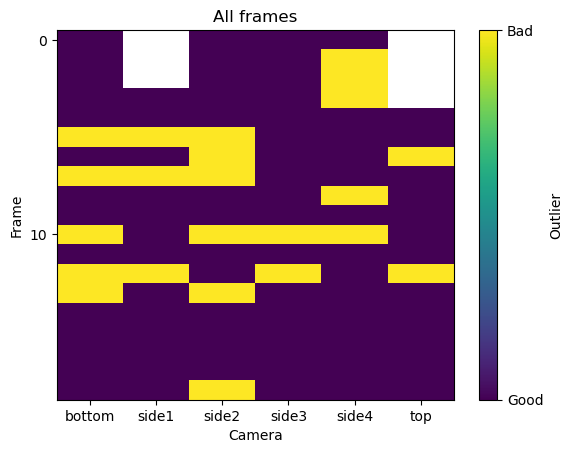

In [21]:
camera_outliers = np.nan * np.zeros((len(frames_to_curate.index.get_level_values("frame").unique()), len(frames_to_curate.camera_copy.unique())))
for i in range(len(frames_to_curate)):
    frame_idx = np.where(frames_to_curate.index.get_level_values("frame").unique() == frames_to_curate.iloc[i, :].name[1])[0][0]
    cam_idx = np.where(np.sort(frames_to_curate.camera_copy.unique()) == frames_to_curate.iloc[i, :].camera_copy)[0][0]
    camera_outliers[frame_idx, cam_idx] = frames_to_curate.iloc[i, :].outlier
plt.imshow(camera_outliers, aspect="auto")
_ = plt.xticks(range(len(frames_to_curate.camera_copy.unique())), np.sort(frames_to_curate.camera_copy.unique()))
plt.xlabel("Camera")
plt.ylabel("Frame")
plt.yticks(np.arange(0, len(frames_to_curate.index.get_level_values("frame").unique()), 10))
plt.title("All frames")
c = plt.colorbar()
c.set_label("Outlier")
c.set_ticks([0, 1])
c.set_ticklabels(["Good", "Bad"])


In [22]:
frames_to_curate.outlier.mean()

0.21495327102803738

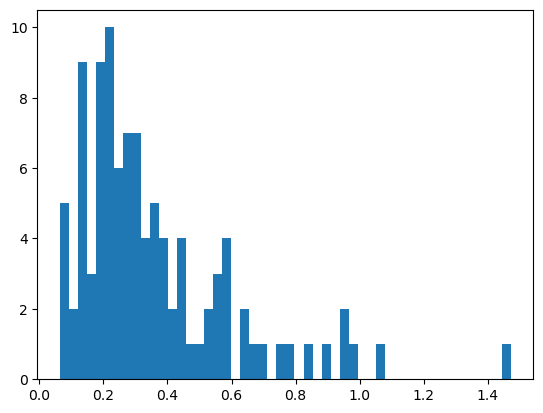

In [23]:
_ = plt.hist(frames_to_curate["max_dist"], bins=50)

In [24]:
removed_frames = 0
updated_frames = 0
perfect_frames = 0

cleaned_annos = annos_dict.copy()
for iFrame, (session, frame) in tqdm(enumerate(grouped.groups.keys())):
    frame_group = grouped.get_group((session, frame))
    frame_cam_outliers = camera_outliers[iFrame, :]

    if np.sum(frame_cam_outliers) == 0:
        # The copied keypoints are already good
        perfect_frames += 1
        continue
        

    elif np.sum(frame_cam_outliers) <= 2:
        updated_frames += 1
        
        # If only a few outlier frames, we can try to correct them
        # Correct the bad cameras with the reprojections from the other cameras

        # Get the good and bad cameras
        bad_cameras = frame_group.camera_copy[frame_cam_outliers[~np.isnan(frame_cam_outliers)].astype(bool)]
        good_cameras = frame_group.camera_copy[~frame_cam_outliers.astype(bool)]

        # Get the 2D points across good cameras for this frame
        for cam in good_cameras:
            img_name = frame_group.img_name[frame_group.camera_copy == cam].values[0]
            anno = annos_dict[img_name]
            keypoint_names = np.array(
                anno["params"]["geometries"]["point"]["objects_to_annotate"]
            )
            uvs = np.zeros((len(keypoint_names), 2)) * np.nan
            for pt in anno["response"]["annotations"]:
                ix = np.where(keypoint_names == pt["label"])[0][0]
                uvs[ix, 0] = pt["x"]
                uvs[ix, 1] = pt["y"]
            frame_coords_uv[cam] = uvs
        
        # Get the 3D points via all good cameras
        cleaned_pts_3d = mcc.geometry.triangulate(  # npoints x 3
            all_uvs=[
                frame_coords_uv[cam] for cam in good_cameras
            ],
            all_extrinsics=[
                all_extrinsics[np.where(camera_names == cam)[0][0]]
                for cam in good_cameras
            ],
            all_intrinsics=[
                all_intrinsics[np.where(camera_names == cam)[0][0]]
                for cam in good_cameras
            ],
        )
        
        # For each bad camera, reproject the 3D points from the good cameras into the uv for that bad camera
        for cam in bad_cameras:
            img_name = frame_group.img_name[frame_group.camera_copy == cam].values[0]
            cleaned_anno = cleaned_annos[img_name]

            cam_idx = np.where(camera_names == cam)[0][0]
            # recompute the 2D points in this left-out camera
            extrinsics = all_extrinsics[cam_idx]
            camera_matrix, dist_coefs = all_intrinsics[cam_idx]
            uvs_cleaned = mcc.geometry.project_points(
                points=cleaned_pts_3d,
                extrinsics=extrinsics,
                camera_matrix=camera_matrix,
                dist_coefs=dist_coefs,
            )
            uvs = np.zeros((len(keypoint_names), 2)) * np.nan
            for pt in cleaned_anno["response"]["annotations"]:
                ix = np.where(keypoint_names == pt["label"])[0][0]
                pt["x"] = uvs[ix, 0]
                pt["y"] = uvs[ix, 1]
    else:
        # remove this frame entirely
        removed_frames += 1
        bad_cameras = frame_group.camera_copy[frame_cam_outliers[~np.isnan(frame_cam_outliers)].astype(bool)]
        for cam in bad_cameras:
            img_name = frame_group.img_name[frame_group.camera_copy == cam].values[0]
            cleaned_annos.pop(img_name)
    
print(f"Removed {removed_frames} / {len(grouped)} frames")
print(f"Updated {updated_frames} / {len(grouped)} frames")
print(f"Perfect {perfect_frames} / {len(grouped)} frames")

19it [00:00, 599.28it/s]

Removed 8 / 19 frames
Updated 4 / 19 frames
Perfect 7 / 19 frames


In [26]:
json.dump(cleaned_annos, open(anno_path.replace(".json", "_cleaned.json"), "w"))